# Base Model - Decision Trees

In [62]:
#importing key libraries
import numpy as np #for numerical calculations
import seaborn as sns #for visualisations
import matplotlib.pyplot as plt #for visualisations
import pandas as pd #for general data use

#importing metrics for model evaluation
from sklearn import metrics
from time import time

#the main packages for modelling and evaluating the model
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree #for visualising the tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV #train-test splitting, evaluating the model, finding best parameters
from sklearn.metrics import confusion_matrix, accuracy_score #for evaluating the model

#ensemble classifiers to fine tune the model
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

## Metrics Combined Functions

In [102]:
##import the functions for calculating model metrics

def apr(y_pred, y_real):
    accuracy = metrics.accuracy_score(y_real, y_pred) #calculating accuracy
    #positive label is 'Yes' as we are predicting those who Churn
    precision = metrics.precision_score(y_real, y_pred, pos_label='Yes') #calculating precision
    recall = metrics.recall_score(y_real, y_pred, pos_label='Yes') #calculating recall
    f1 = metrics.f1_score(y_real, y_pred, pos_label='Yes') #calculating f1 - harmonic means of precision and recall
    
    print(f"Accuracy:{accuracy}")
    print(f"Precision:{precision}")
    print(f"Recall:{recall}")
    print(f"F1:{f1}")
    return accuracy, precision, recall, f1


##confusion matrix display function

def produce_confusion(positive_label, negative_label, cut_off, df, y_pred_name, y_real_name):
    
    #Set pred to 0 or 1 depending on whether it's higher than the cut_off point.
    
    if cut_off != 'binary':      
        df['pred_binary'] = np.where(df[y_pred_name] > cut_off , 1, 0)
    else: 
        df['pred_binary'] = df[y_pred_name]
    
    #Build the CM
    cm = confusion_matrix(df[y_real_name], df['pred_binary'])  
    
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='g'); 

    # labels, title, ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('Real labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels([negative_label, positive_label])
    ax.yaxis.set_ticklabels([negative_label, positive_label]);

    print('Test accuracy = ', accuracy_score(df[y_real_name], df['pred_binary']))

    return accuracy_score(df[y_real_name], df['pred_binary'])

## Loading Dataframe

In [3]:
#reading csv and creating dataframe
swan = pd.read_csv('swan_data.csv')
swan.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,Competitor had better devices


# EDA + Data Cleaning

In [4]:
#checking for nulls - nulls mostly found in churn reason
#churn reason won't be used for modelling so nulls are ignored
swan.isnull().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Reason         5174
dtype: int64

In [5]:
#checking datatypes - need to convert object types to numerical 
swan.dtypes

CustomerID            object
Count                  int64
Country               object
State                 object
City                  object
Zip Code               int64
Lat Long              object
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Label           object
Churn Value            int64
Churn Reason          object
dtype: object

In [6]:
#dropping nulls (lone spaces) in Total Charges
swan = swan.drop(swan[swan['Total Charges'] == ' '].index)

In [7]:
#confirming nulls have been removed
swan.loc[swan['Total Charges'] == ' ']

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Reason


In [8]:
#casting Total Charges as float
swan['Total Charges'] = swan['Total Charges'].astype(float)

In [9]:
#confirming Total Charges is now a float
swan.dtypes

CustomerID            object
Count                  int64
Country               object
State                 object
City                  object
Zip Code               int64
Lat Long              object
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges        float64
Churn Label           object
Churn Value            int64
Churn Reason          object
dtype: object

# Feature Engineering
## Mapping non-numerical variables

In [10]:
#FE - mapping categorical variables
#different/multiple categories 
swan['Gender'] = swan['Gender'].map({'Male':0, 'Female':1, 0:0, 1:1})
swan['Payment Method'] = swan['Payment Method'].map({'Mailed check':0, 'Electronic check':1, 'Bank transfer (automatic)':2, 'Credit card (automatic)':3, 0:0, 1:1, 2:2, 3:3})
swan['Contract']  = swan['Contract'].map({'Month-to-month':0, 'One year':1, 'Two year':2, 0:0, 1:1, 2:2})
swan['Internet Service'] = swan['Internet Service'].map({'No':0, 'Fiber optic':1, 'DSL':2, 0:0, 1:1, 2:2})

#no:0, yes:1
swan['Paperless Billing'] = swan['Paperless Billing'].map({'No':0, 'Yes':1, 0:0, 1:1})
swan['Senior Citizen'] = swan['Senior Citizen'].map({'No':0, 'Yes':1, 0:0, 1:1})
swan['Partner'] = swan['Partner'].map({'No':0, 'Yes':1, 0:0, 1:1})
swan['Dependents'] = swan['Dependents'].map({'No':0, 'Yes':1, 0:0, 1:1})
swan['Phone Service'] = swan['Phone Service'].map({'No':0, 'Yes':1, 0:0, 1:1})

#no:0, no phone/internet service:1, yes:2
swan['Multiple Lines'] = swan['Multiple Lines'].map({'No':0, 'No phone service':1, 'Yes':2, 0:0, 1:1, 2:2})
swan['Streaming TV'] = swan['Streaming TV'].map({'No':0, 'No internet service':1, 'Yes':2, 0:0, 1:1, 2:2})
swan['Streaming Movies'] = swan['Streaming Movies'].map({'No':0, 'No internet service':1, 'Yes':2, 0:0, 1:1, 2:2})
swan['Online Security'] = swan['Online Security'].map({'No':0, 'No internet service':1, 'Yes':2, 0:0, 1:1, 2:2})
swan['Online Backup'] = swan['Online Backup'].map({'No':0, 'No internet service':1, 'Yes':2, 0:0, 1:1, 2:2})
swan['Device Protection'] = swan['Device Protection'].map({'No':0, 'No internet service':1, 'Yes':2, 0:0, 1:1, 2:2})
swan['Tech Support'] = swan['Device Protection'].map({'No':0, 'No internet service':1, 'Yes':2, 0:0, 1:1, 2:2})


In [47]:
#temporary dataframe for selected columns - removed sensitive or irrelevant info
swan_columns = swan[[
        'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Value', 'Churn Label'
                ]]

# Further EDA

## Correlation Matrix

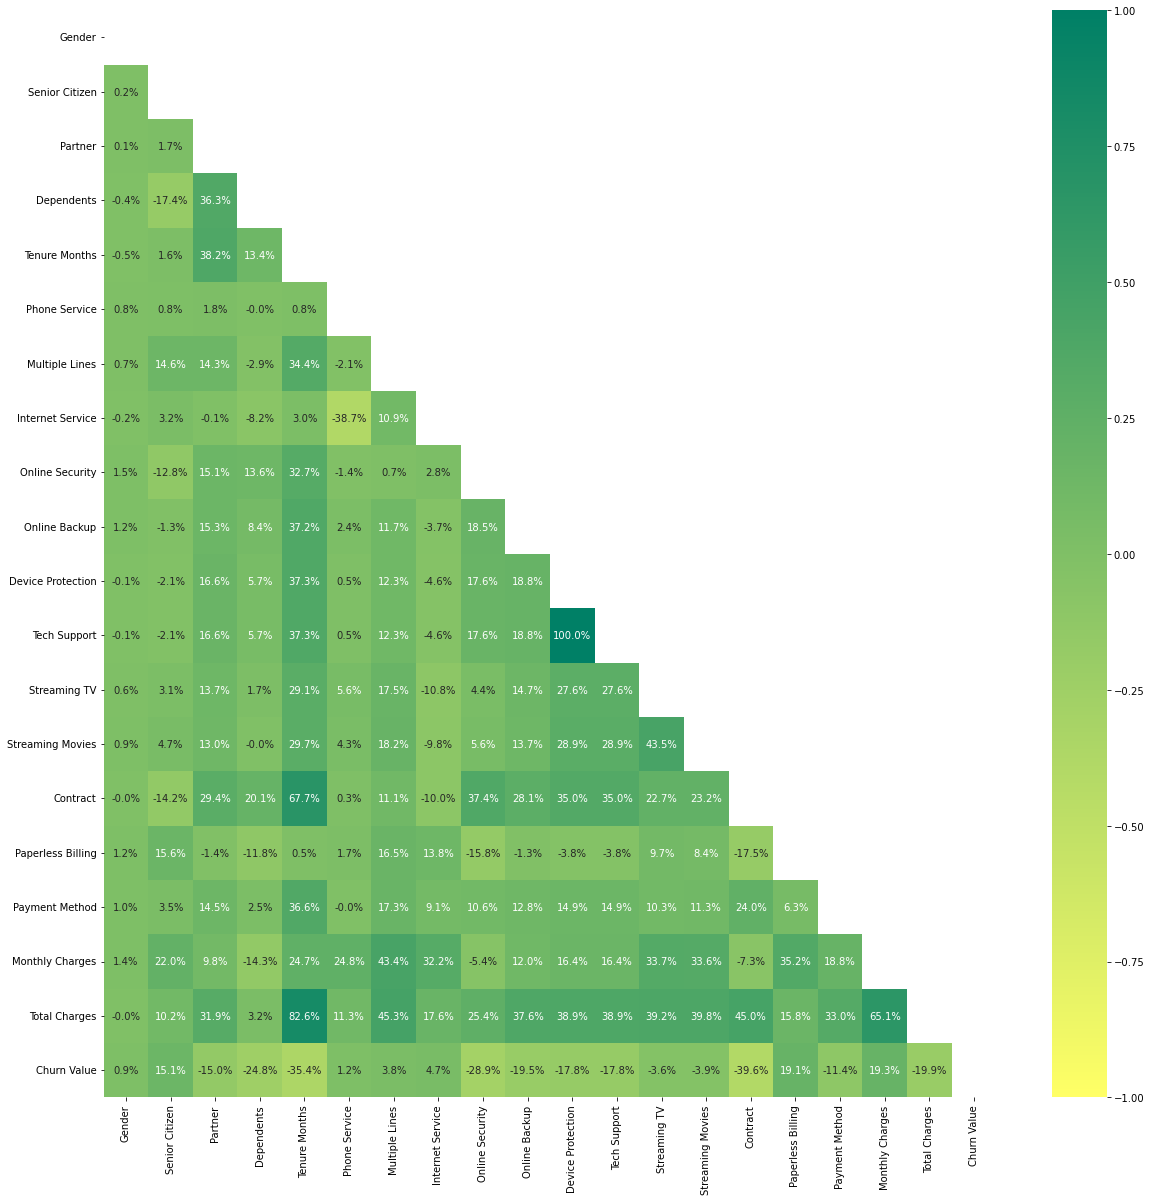

<Figure size 432x288 with 0 Axes>

In [50]:
#plotting a heatmap of the correlation matrix
plt.figure(figsize = (20,20))
sns.heatmap(data=swan_columns.corr(),
           annot = True,  #displaying values on the heatmap
           cmap = 'summer_r', #colour palette
           fmt = '.1%', #the display precision
           vmin = -1, #where to set the scale from
           vmax = 1, #where to end the scale
           mask = np.triu(swan_columns.corr()) )#adding a triangular masking, because triangles (above and below) are mirrored - identical
plt.show()
plt.savefig('swan_correlation') #saving the correlation matrix as a png file

#### Insights from the correlation matrix:
* Contract and Tenure Months are most highly negatively correlated with Churn Value: longer contracts and the longer tenure months incentivise a customer to stay with Swan Teleco.
* Online security is highly negatively correlated with Churn Value: having online security incentivises a customer to stay with Swan Teleco.
* Higher monthly charges correlated with Churn Value.
* Tech support and Device Protection are 100% correlated: customers who receive tech support receive device protection.

## Pairplots
### Visualising nature of relationships between features

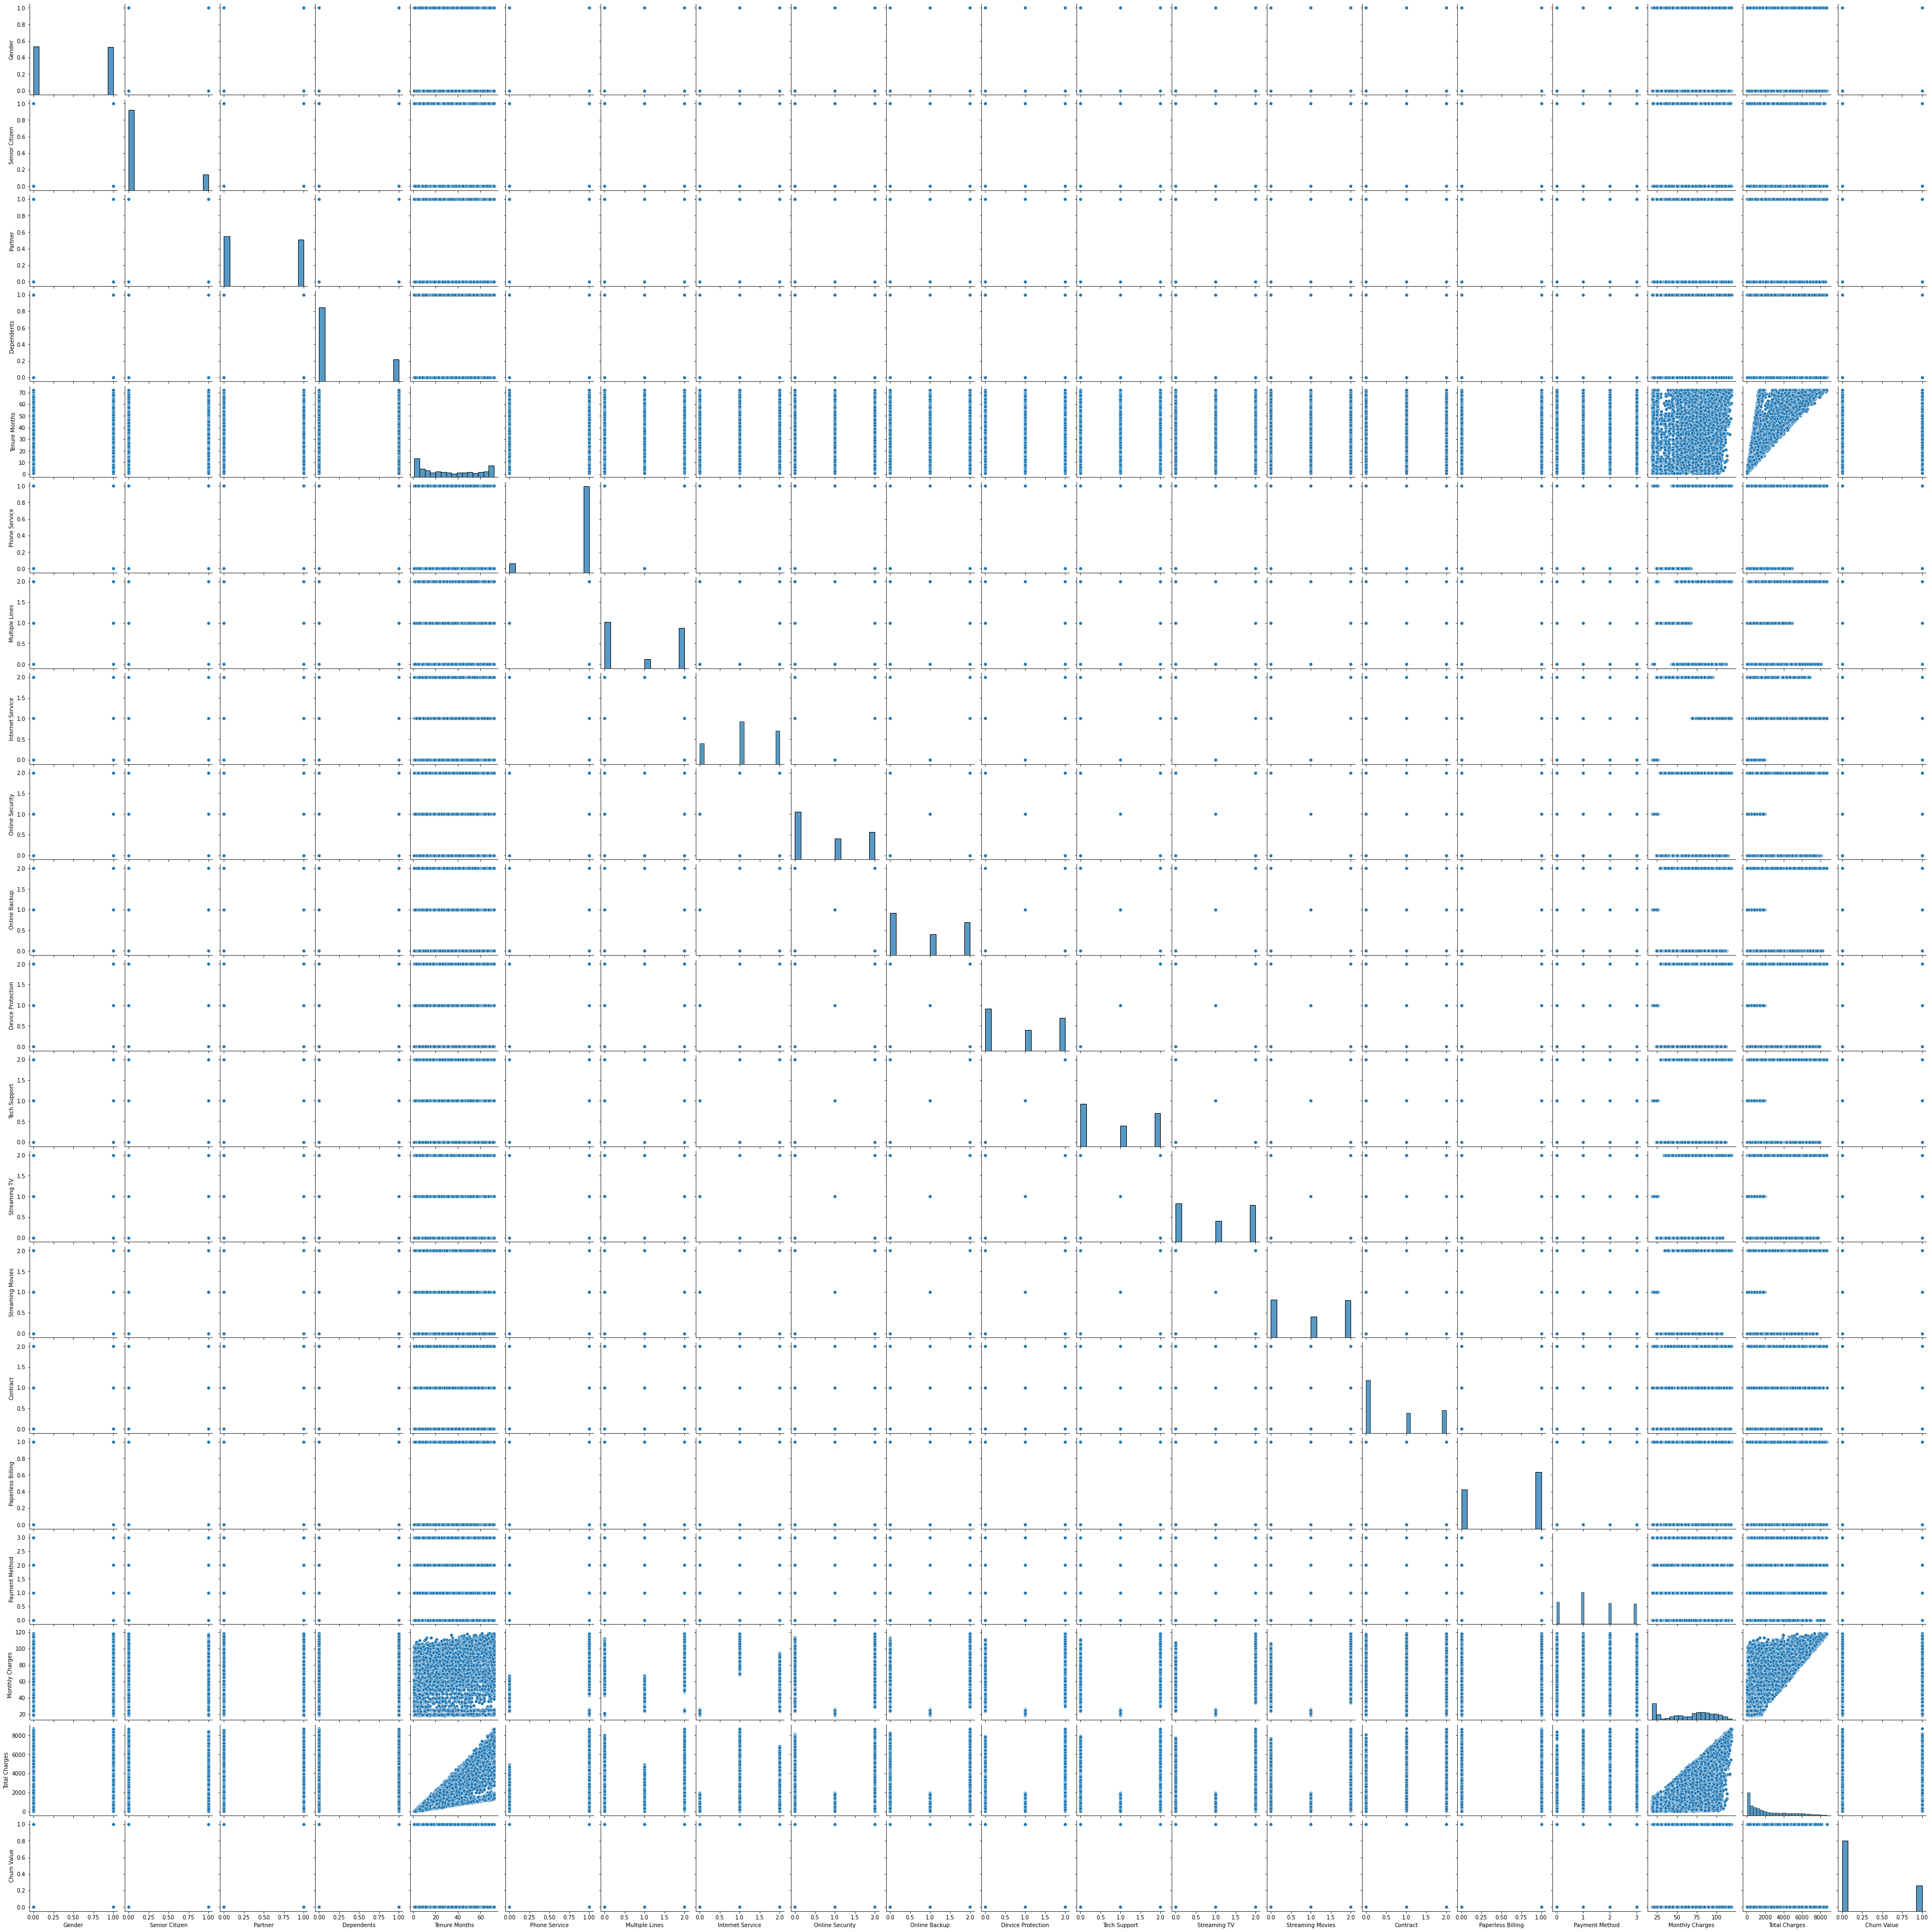

In [45]:
sns.pairplot(swan_columns)
plt.show()

#### Insights from pairplots:
* Linear relationship observed between Monthly Charges and Total Charges
* Linear relationship Tenure Months and Total Charges
* No other noticeable relationships, due to binary nature of most features

### Visualisations/EDA carried in Tableau:
* https://public.tableau.com/app/profile/elai.lb/viz/SwanViusals/Sheet1?publish=yes
* https://public.tableau.com/app/profile/nundon.vaghadia/viz/sWANProjecttabue/Dashboard1?publish=yes

# Modelling

### Feature Selection

In [17]:
#selecting the features - removal of sensitive features, inclusion of relevant numerical features
feature_cols = [
        'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges'
                ]

### Train test split

In [18]:
#divide data into training and testing sets - 80% train, 20% test.
X_train, X_test, y_train, y_test = train_test_split(swan_columns[feature_cols], swan_columns['Churn Label'], test_size = 0.2, random_state = 42)

## Fine Tuning the Model

### Random Forest Classifier

In [19]:
#empty random forests object
rf = RandomForestClassifier(n_estimators=100)

### Grid Search for best parameters

In [20]:
#establishing list of hyperparameters for grid search
rf_params = {
    'n_estimators': [300],
    'max_depth': [16, 18],
    'max_features': [8, 10],
    'min_samples_split' : [130],
    'min_samples_leaf' : [10]
}

# grid search with 10-fold cross validation
gs = GridSearchCV(rf, 
                  param_grid=rf_params,  
                  cv=10)

# fit to training data
gs.fit(X_train, y_train)

# best scores
print(gs.best_score_)

0.8053364980436527


In [21]:
#best parameters from grid search
gs.best_params_

{'max_depth': 18,
 'max_features': 10,
 'min_samples_leaf': 10,
 'min_samples_split': 130,
 'n_estimators': 300}

## Model Evaluation

In [22]:
#establishing best parameters
rf = gs.best_estimator_

#comparing training and testing accuracy to determine fitting of the model
print(f'The Training accuracy using RFC is: {rf.score(X_train, y_train)}')
print(f'The Testing accuracy using RFC is: {rf.score(X_test, y_test)}')

The Training accuracy using RFC is: 0.8199111111111111
The Testing accuracy using RFC is: 0.8173418621179815


The training and testing accuracies have a 0.002 difference - implying a good fit (no major overfit or underfit)

### Cross validation scores

In [27]:
#determining accuracies between 10 folds of the training set using cross validation
rf_score = cross_val_score(rf, X_train, y_train, cv=10)

In [28]:
print(f'Random Forest Classifier - Cross Validation score: {rf_score}')

Random Forest Classifier - Cross Validation score: [0.8383659  0.78685613 0.77975133 0.81527531 0.79218472 0.8113879
 0.80604982 0.77758007 0.83451957 0.8113879 ]


In [29]:
#average accuracy score between the folds
sum(rf_score) / len(rf_score)

0.8053358659443879

## Predicting Churn Labels 
### + Probabilites of Churn

#### Training set

In [53]:
# creating target predictions for training data using the model
train_results = X_train.copy()
train_results['y_pred'] = rf.predict(X_train)
train_results['y_real'] = y_train
# creating target prediction probabilities for training data using the model
train_results['y_prob'] = rf.predict_proba(X_train)[:,1]

train_results.head()

,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,y_pred,y_real,y_prob
6030,0,1,0,24,1,2,1,0,0,0,...,2,2,0,1,1,93.00,2248.05,Yes,No,0.581056
3409,0,1,0,40,1,2,1,0,0,0,...,0,0,0,1,3,78.85,3126.85,No,No,0.484818
5482,0,1,0,4,1,2,2,0,0,2,...,2,0,0,0,1,65.60,250.10,No,No,0.369051
5523,0,0,0,4,1,0,2,0,0,0,...,2,0,0,0,3,55.50,227.35,No,No,0.383016
6337,0,1,1,64,1,2,0,1,1,1,...,1,1,1,0,0,24.90,1595.50,No,No,0.012771


#### Testing set

In [55]:
# creating target predictions for testing data using the model
test_results = X_test.copy() #create copy of X_test
test_results['y_pred'] = rf.predict(X_test) #predict on X_test and attach
test_results['y_real'] = y_test #attach the real values
# creating target prediction probabilities for testing data using the model
test_results['y_prob'] = rf.predict_proba(X_test)[:,1]

test_results.head()

,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,y_pred,y_real,y_prob
2478,0,1,0,42,1,2,0,1,1,1,...,1,1,2,0,1,25.25,1108.20,No,No,0.024413
6783,0,0,0,43,0,1,2,0,0,2,...,0,2,1,0,1,44.15,1931.30,No,No,0.171959
6125,0,0,0,27,1,0,1,0,0,2,...,0,2,0,1,1,89.20,2383.60,No,No,0.495100
3052,0,0,0,65,1,0,0,1,1,1,...,1,1,2,1,3,19.55,1218.65,No,No,0.004869
4097,0,0,0,29,1,2,2,0,0,0,...,2,2,1,1,3,71.00,2080.10,No,No,0.171949


In [99]:
test_results.loc[(test_results['y_real'] == 'Yes' )& (test_results['y_pred'] == 'Yes')]

,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,...,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,y_pred,y_real,y_prob,pred_binary
1192,0,0,0,3,1,0,1,0,0,0,...,2,0,0,1,85.80,272.20,Yes,Yes,0.646272,Yes
1287,0,0,0,1,0,1,2,0,0,0,...,0,0,1,1,35.75,35.75,Yes,Yes,0.607808,Yes
811,0,0,0,1,0,1,2,0,0,0,...,0,0,1,0,25.10,25.10,Yes,Yes,0.578877,Yes
1078,0,0,0,7,1,2,1,0,0,0,...,0,0,0,1,73.60,520.00,Yes,Yes,0.540053,Yes
1038,0,0,0,1,1,0,1,0,0,0,...,2,0,0,1,78.65,78.65,Yes,Yes,0.856257,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,1,0,0,30,1,2,1,0,2,0,...,2,0,1,1,99.70,2967.35,Yes,Yes,0.617496,Yes
1512,0,1,0,4,1,2,1,0,2,0,...,2,0,1,1,97.95,384.50,Yes,Yes,0.813852,Yes
1768,1,0,0,3,1,2,1,0,0,2,...,0,0,0,1,91.05,289.10,Yes,Yes,0.713268,Yes
1212,0,0,0,2,1,2,1,0,0,0,...,0,0,1,1,75.55,166.30,Yes,Yes,0.727908,Yes


# Further Model Evaluation

## Metrics 

In [103]:
#caluating accuracy, precision, recall and f1 score for train scores
train_scores = apr(train_results['y_pred'], train_results['y_real'])

Accuracy:0.8199111111111111
Precision:0.7013100436681222
Recall:0.5447761194029851
F1:0.6132111492936235


In [104]:
#caluating accuracy, precision, recall and f1 score for test scores
test_scores = apr(test_results['y_pred'], test_results['y_real'])

Accuracy:0.8173418621179815
Precision:0.7331081081081081
Recall:0.549367088607595
F1:0.6280752532561505


Test accuracy =  0.8199111111111111


0.8199111111111111

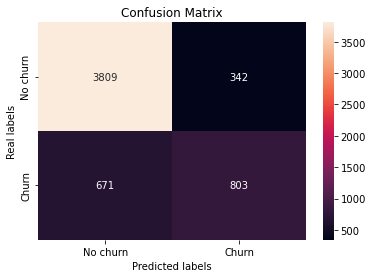

In [101]:
produce_confusion('Churn', 'No churn', 'binary', train_results, 'y_pred', 'y_real')

Test accuracy =  0.8173418621179815


0.8173418621179815

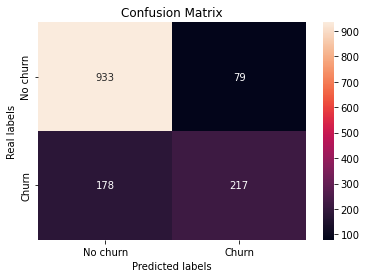

In [100]:
produce_confusion('Churn', 'No churn', 'binary', test_results, 'y_pred', 'y_real')

#### Insights from further model evaluation:
* Maximised accuracy (over 80%): Majority of True Churned Customers and True No Churn Customers captured in both the training and testing datasets.
* Precision over 70%: 70% of Churned Customers predicted correctly.
* Compromised recall (54%): 54% of Churned Customers captured, due to imbalance of target classes in dataset (less Churn than No Churn).
* F1 Score over 60%: despite compromosing recall, the model can still accurately capture and predict the majority of Churned Customers correctly.

### Merging train and test results

In [34]:
X = pd.concat([train_results, test_results])
X.head()

,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,y_pred,y_real,y_prob
6030,0,1,0,24,1,2,1,0,0,0,...,2,2,0,1,1,93.00,2248.05,Yes,No,0.581056
3409,0,1,0,40,1,2,1,0,0,0,...,0,0,0,1,3,78.85,3126.85,No,No,0.484818
5482,0,1,0,4,1,2,2,0,0,2,...,2,0,0,0,1,65.60,250.10,No,No,0.369051
5523,0,0,0,4,1,0,2,0,0,0,...,2,0,0,0,3,55.50,227.35,No,No,0.383016
6337,0,1,1,64,1,2,0,1,1,1,...,1,1,1,0,0,24.90,1595.50,No,No,0.012771


In [35]:
#checking to see if columns were added
X.shape

(7032, 21)

### Merging Customer ID

In [36]:
#creating a dataframe with just customer IDs (for merging)
swan_id = swan['CustomerID'].copy()
swan_id.head()

0    3668-QPYBK
1    9237-HQITU
2    9305-CDSKC
3    7892-POOKP
4    0280-XJGEX
Name: CustomerID, dtype: object

In [37]:
#creating a copy of new dataframe
swan_X = X.copy()
#renaming target probabilities to a more understandable name
swan_X.rename(columns={"y_prob": "Churn Probability"}, inplace=True)
#rounding probabilites to 3 decimal places
swan_X['Churn Probability'] = swan_X['Churn Probability'].apply(lambda x: round(x, 3))
swan_list = swan_X.join(swan_id, how='outer') #joining with customer id

In [38]:
#isolating customer id and churn probability
swan_list_probs = swan_list[['CustomerID', 'Churn Probability']].copy()
#order by descending probability
swan_list_probs = swan_list_probs.sort_values(by = 'Churn Probability', ascending=False)
swan_list_probs.head()

,CustomerID,Churn Probability
251,8603-IJWDN,0.88
1203,1069-XAIEM,0.88
839,8149-RSOUN,0.88
515,9497-QCMMS,0.88
1255,9300-AGZNL,0.88


In [39]:
#exporting the dataframe as a csv file, removing the index
swan_list_probs.to_csv('Churn_ALL_draft.csv', index=False)

## List of 500 customers most likely to churn

In [40]:
swan_list = swan_list.loc[swan_list['y_real'] == 'No'] #removing customers who have already churned
swan_list.head()

,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,...,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,y_pred,y_real,Churn Probability,CustomerID
1869,0,1,0,1,0,1,2,0,2,0,...,0,0,1,1,29.85,29.85,Yes,No,0.569,7590-VHVEG
1870,0,0,0,34,1,0,2,2,0,2,...,0,1,0,0,56.95,1889.50,No,No,0.057,5575-GNVDE
1871,0,0,0,45,0,1,2,2,0,2,...,0,1,0,2,42.30,1840.75,No,No,0.065,7795-CFOCW
1872,0,0,1,22,1,2,1,0,2,0,...,0,0,1,3,89.10,1949.40,No,No,0.118,1452-KIOVK
1873,0,0,0,10,0,1,2,2,0,0,...,0,0,0,0,29.75,301.90,No,No,0.271,6713-OKOMC


In [41]:
#ordering customers by highest probability to churn, limiting to first 500 
swan_500 = swan_list.sort_values(by = 'Churn Probability', ascending=False).head(500) 
#limiting to only the customer ID and churn probability columns
swan_500_final = swan_500[['CustomerID', 'Churn Probability']].copy()

In [42]:
swan_500_final.head()

,CustomerID,Churn Probability
5906,4912-PIGUY,0.874
5657,7577-SWIFR,0.868
2676,7439-DKZTW,0.867
2215,1452-VOQCH,0.854
6213,1628-BIZYP,0.851


In [43]:
#exporting the dataframe as a csv file, removing the index
swan_500_final.to_csv('500_churn_draft.csv', index=False)